# CampaignSense — Segmentação de Clientes

Este notebook implementa a segmentação comportamental de clientes da POC CampaignSense, com foco na leitura estrutural e estratégica da base em contextos de CRM Analytics.

A segmentação é tratada como um artefato analítico descritivo, independente da modelagem supervisionada, com finalidade contextual e interpretativa, apoiando a compreensão de padrões de valor, engajamento e uso de canais ao nível de grupos homogêneos de clientes.

---

## Escopo analítico

* A segmentação é construída **exclusivamente sobre o conjunto de treino**, preservando isolamento informacional.
* O espaço de segmentação é composto apenas por **variáveis comportamentais**, relacionadas a consumo, histórico de campanhas e canais.
* Variáveis demográficas, identificadores e a variável alvo `Response` **são explicitamente excluídas** do processo de clusterização.
* As decisões metodológicas priorizam **interpretabilidade, estabilidade e aplicabilidade em CRM**, em detrimento de otimização algorítmica.

---

## Abordagem metodológica

* Derivação de variáveis determinísticas de alto nível para caracterização comportamental (ex.: métricas agregadas de consumo e histórico de campanhas).
* Definição de um espaço de segmentação enxuto e defensável, cobrindo múltiplos eixos de comportamento.
* Pré-processamento com transformação logarítmica de variáveis monetárias e padronização.
* Clusterização via **K-Means**, com definição pragmática do número de clusters baseada em:
  * separação consistente entre grupos;
  * ausência de segmentos residuais;
  * facilidade de interpretação e comunicação.
* Profiling dos segmentos com métricas orientadas a negócio (valor, engajamento, resposta e canais).

---

## Persistência de artefatos analíticos

Ao final desta etapa, são persistidos os seguintes artefatos:

* `segments.parquet` — Dataset contendo o identificador do cliente (ID) e o identificador do segmento atribuído (segment_id).
* `segment_profile.csv` — Tabela consolidada de perfil dos segmentos, com métricas agregadas de valor e engajamento.

## 1. Setup e carregamento dos dados

In [1]:
# Governança: habilita import de módulos do projeto a partir do diretório /notebooks
import sys
sys.path.insert(0, "..")

# Standard library
import json
from datetime import datetime

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Local
from src.paths import (
    PLOTS_FOLDER,    
    PROCESSED_TRAIN,
    PROCESSED_SPLIT_METADATA,
    SEGMENTS_PROFILE,
    SEGMENTS_OUTPUT,

)

In [2]:
# Governança: seed global para reprodutibilidade do notebook
SEED = 42
np.random.seed(SEED)

# Configuração de exibição (não altera a persistência dos dados)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)
sns.set_theme(style="whitegrid", context="notebook")

In [3]:
train = pd.read_parquet(PROCESSED_TRAIN)
print(f"Split train: {train.shape[0]} linhas x {train.shape[1]} colunas")

with open(PROCESSED_SPLIT_METADATA, "r", encoding="utf-8") as f:
    split_meta = json.load(f)

print(
    "Split meta | strategy:", split_meta.get("strategy"),
    "| seed:", split_meta.get("seed"),
    "| base_rate(train):", f'{split_meta["base_rate"]["train"]:.2%}'
)

Split train: 1431 linhas x 31 colunas
Split meta | strategy: stratified_random | seed: 42 | base_rate(train): 14.95%


## 2. Derivações comportamentais determinísticas

In [4]:
# Variáveis auxiliares (derivações determinísticas)
consumption_cols = [
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
]

accepted_cols = [
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
]

df = train.copy()

df["TotalSpend"] = df[consumption_cols].sum(axis=1)
df["AcceptedCmpTotal"] = df[accepted_cols].sum(axis=1)

In [5]:
df["TotalSpend"].describe()

count   1431.0000
mean     615.7575
std      605.3762
min        5.0000
25%       70.0000
50%      410.0000
75%     1070.5000
max     2525.0000
Name: TotalSpend, dtype: float64

In [6]:
df["AcceptedCmpTotal"].value_counts().sort_index()

AcceptedCmpTotal
0    1132
1     208
2      52
3      30
4       9
Name: count, dtype: int64

> As variáveis derivadas são utilizadas exclusivamente para fins de segmentação e profiling, não participando de etapas preditivas ou de decisão supervisionada.

## 3. Definição do espaço analítico de segmentação

In [7]:
# Espaço de segmentação (features comportamentais)
cluster_features = [
    "TotalSpend",          
    "Recency",             
    "AcceptedCmpTotal",    
    "NumWebPurchases",     
    "NumCatalogPurchases",
    "NumStorePurchases", 
]

In [8]:
X = df[cluster_features].copy()
X.head()

,TotalSpend,Recency,AcceptedCmpTotal,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
0,573,81,0,4,4,9
1,34,56,0,1,0,3
2,1363,41,1,6,6,7
3,777,24,0,4,5,7
4,910,56,0,6,4,12


> O espaço de segmentação é definido a partir de eixos comportamentais complementares (valor, recência, histórico de campanhas e canais), priorizando interpretabilidade e aplicabilidade em contextos de CRM.

## 4. Pré-processamento do espaço de segmentação

In [9]:
# Transformação para reduzir assimetria de valor monetário
X["TotalSpend"] = np.log1p(X["TotalSpend"])

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled.shape

(1431, 6)

## 5. Definição da estrutura de clusterização

In [12]:
results = []
n = X_scaled.shape[0]

for k in range(3, 7):
    km = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
    labels = km.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)

    # menor cluster em %
    min_pct = (pd.Series(labels).value_counts(normalize=True).min()) * 100

    results.append({
        "k": k,
        "silhouette": sil,
        "min_cluster_pct": min_pct,
    })

df_k = pd.DataFrame(results).sort_values("k")
df_k

,k,silhouette,min_cluster_pct
0,3,0.3502,9.7135
1,4,0.3223,6.2893
2,5,0.2536,6.2893
3,6,0.2521,6.2893


In [13]:
# Regra: evitar cluster "anão" (< 5%) e preferir o menor K com silhouette razoável
CUTOFF_MIN_PCT = 5.0

candidates = df_k[df_k["min_cluster_pct"] >= CUTOFF_MIN_PCT].copy()
if candidates.empty:
    print("Nenhum K atende min_cluster_pct >= 5%. Escolha manual necessária.")
    K_FINAL = int(df_k.sort_values("silhouette", ascending=False).iloc[0]["k"])
else:
    # pega o melhor silhouette dentro dos candidatos e escolhe o menor K dentro de uma margem
    best_sil = candidates["silhouette"].max()
    margin = 0.02  # tolerância para escolher K menor sem perder muito
    shortlist = candidates[candidates["silhouette"] >= (best_sil - margin)]
    K_FINAL = int(shortlist.sort_values("k").iloc[0]["k"])

print("K_FINAL =", K_FINAL)

K_FINAL = 3


In [14]:
display(df_k.style.format({"silhouette": "{:.4f}", "min_cluster_pct": "{:.2f}"}))

,k,silhouette,min_cluster_pct
0,3,0.3502,9.71
1,4,0.3223,6.29
2,5,0.2536,6.29
3,6,0.2521,6.29


> O número de clusters é definido como 3, priorizando separação consistente entre grupos, ausência de segmentos residuais e interpretabilidade para uso em CRM.

## 6. Ajuste do modelo final de segmentação

In [15]:
kmeans = KMeans(
    n_clusters=K_FINAL,
    random_state=SEED,
    n_init="auto"
)

segment_id = kmeans.fit_predict(X_scaled)

In [16]:
train_seg = train[["ID", "Response"]].copy()
train_seg["segment_id"] = segment_id

train_seg.head()

,ID,Response,segment_id
0,310,0,0
1,5012,0,1
2,4767,0,2
3,4944,0,0
4,2683,0,0


In [17]:
train_seg.shape

(1431, 3)

## 7. Profiling dos segmentos

In [18]:
# Base para profiling (reintroduz variáveis auxiliares)
profile_df = train.copy()

profile_df["TotalSpend"] = df["TotalSpend"]
profile_df["AcceptedCmpTotal"] = df["AcceptedCmpTotal"]
profile_df["segment_id"] = segment_id

In [19]:
segment_profile = (
    profile_df
    .groupby("segment_id")
    .agg(
        n_customers=("ID", "count"),
        response_rate=("Response", "mean"),
        median_total_spend=("TotalSpend", "median"),
        median_recency=("Recency", "median"),
        mean_accepted_cmp=("AcceptedCmpTotal", "mean"),
        mean_web_purchases=("NumWebPurchases", "mean"),
        mean_catalog_purchases=("NumCatalogPurchases", "mean"),
        mean_store_purchases=("NumStorePurchases", "mean"),
    )
    .reset_index()
)

segment_profile

,segment_id,n_customers,response_rate,median_total_spend,median_recency,mean_accepted_cmp,mean_web_purchases,mean_catalog_purchases,mean_store_purchases
0,0,632,0.1266,908.0000,51.0000,0.1661,5.8291,3.9114,8.1503
1,1,660,0.0864,65.0000,49.0000,0.0864,2.1424,0.5212,3.2348
2,2,139,0.5540,1617.0000,42.0000,1.9856,5.7410,6.6187,7.8201


In [20]:
segment_profile["pct_customers"] = (
    segment_profile["n_customers"] / segment_profile["n_customers"].sum()
)

segment_profile = segment_profile[
    [
        "segment_id",
        "n_customers",
        "pct_customers",
        "response_rate",
        "median_total_spend",
        "median_recency",
        "mean_accepted_cmp",
        "mean_web_purchases",
        "mean_catalog_purchases",
        "mean_store_purchases",
    ]
]

segment_profile = segment_profile.sort_values(
    by="median_total_spend", ascending=False
)

segment_profile

,segment_id,n_customers,pct_customers,response_rate,median_total_spend,median_recency,mean_accepted_cmp,mean_web_purchases,mean_catalog_purchases,mean_store_purchases
2,2,139,0.0971,0.5540,1617.0000,42.0000,1.9856,5.7410,6.6187,7.8201
0,0,632,0.4416,0.1266,908.0000,51.0000,0.1661,5.8291,3.9114,8.1503
1,1,660,0.4612,0.0864,65.0000,49.0000,0.0864,2.1424,0.5212,3.2348


### Leitura executiva dos segmentos

**Segmento 2 — High Value / Engaged (≈10% da base)**

* Maior gasto mediano da base
* Taxa de resposta significativamente elevada (~55%)
* Histórico consistente de campanhas aceitas
* Perfil omnichannel equilibrado

**Leitura analítica:** segmento com alta concentração de valor e forte resposta histórica, apresentando elevada prioridade em estratégias orientadas a lucro.

---

**Segmento 0 — Medium Value / Active (≈44% da base)**

* Gasto relevante, com taxa de resposta moderada
* Histórico limitado de campanhas aceitas
* Uso intensivo de canais, com predominância de loja física

**Leitura analítica:** segmento com potencial incremental, cuja ativação exige critérios seletivos para preservação de eficiência orçamentária.

---

**Segmento 1 — Low Value / Inactive (≈46% da base)**

* Gasto médio significativamente inferior
* Menor taxa de resposta observada
* Baixo engajamento histórico com campanhas

**Leitura analítica:** segmento com baixo retorno esperado, tendendo a apresentar eficiência limitada em estratégias de profit targeting.

---

**Síntese:**
A segmentação evidencia uma base heterogênea, na qual uma fração minoritária concentra valor e resposta, enquanto uma parcela expressiva da base apresenta baixo potencial de retorno incremental.

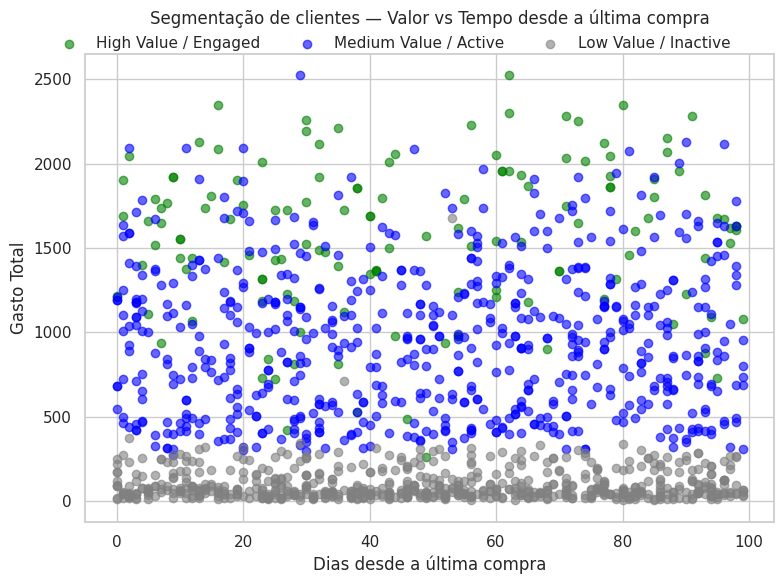

In [21]:
# Visualização da separação dos clusters
fig, ax = plt.subplots(figsize=(8, 6))

color_map = {
    2: "green",   # High Value / Engaged
    0: "blue",    # Medium Value / Active
    1: "gray",    # Low Value / Inactive
}

handles = []
labels = []

for seg_id, color in color_map.items():
    subset = profile_df[profile_df["segment_id"] == seg_id]
    sc = ax.scatter(
        subset["Recency"],
        subset["TotalSpend"],
        color=color,
        alpha=0.6
    )
    handles.append(sc)
    labels.append(
        {
            2: "High Value / Engaged",
            0: "Medium Value / Active",
            1: "Low Value / Inactive",
        }[seg_id]
    )

ax.set_xlabel("Dias desde a última compra")
ax.set_ylabel("Gasto Total")
ax.set_title("Segmentação de clientes — Valor vs Tempo desde a última compra\n", fontsize=12)

# Legenda
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 0.95)
)

plt.tight_layout()


plt.savefig(
    PLOTS_FOLDER / "segments_scatter_value_vs_last_purchase.png",
    dpi=150,
    bbox_inches="tight"
)

plt.show()

## 8. Persistência dos artefatos analíticos

In [22]:
segments_out = train_seg[["ID", "segment_id"]].copy()

# Persistência da atribuição de segmentos ao nível individual
segments_out.to_parquet(SEGMENTS_OUTPUT, index=False)

# Persistência da tabela consolidada de perfil dos segmentos
segment_profile.to_csv(SEGMENTS_PROFILE, index=False)

## Encerramento

Este notebook consolida a segmentação comportamental de clientes como um produto analítico da POC CampaignSense.

Ao término desta etapa, a POC passa a dispor de:

* uma segmentação consistente da base de treino, construída exclusivamente a partir de variáveis comportamentais;
* perfis de clientes claramente diferenciados em termos de valor, engajamento histórico e padrão de canal;
* evidência objetiva da heterogeneidade da base, com identificação de segmentos estruturalmente mais e menos atrativos para campanhas;
* artefatos analíticos persistidos, assegurando rastreabilidade e suporte à leitura estratégica.